In [212]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import spatial
from collections import Counter
from random import sample
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [4]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid'] 

In [5]:
ref_annot = pd.read_csv('../data/raw/ref_annot.csv')

In [6]:
g4_in_dloop = [65, 66, 67, 1, 2, 3, 4]

In [7]:
g4_functional = [1, 65]

In [196]:
g4_id_loc = [[*range(1,68)], ['D_loop', 'D_loop', 'D_loop', 'D_loop',
                            'rRNA', 'rRNA', 'rRNA', 
                            'tRNA', 
                            'ND1', 'ND1', 'ND1', 'ND1', 'ND1', 'ND1', 
                            'tRNA', 'tRNA', 
                            'ND2', 'ND2', 'ND2', 'ND2', 
                            'COX1', 'COX1', 'COX1', 
                            'COX2', 'COX2', 
                            '-',
                            'ATP8', 
                            'ATP6', 'ATP6', 'ATP6', 
                            'COX3', 'COX3', 'COX3', 
                            'ND3', 'ND3', 
                            'ND4L', 
                            'ND4', 'ND4', 'ND4', 'ND4', 'ND4', 'ND4', 'ND4', 'ND4', 
                            'ND5', 'ND5', 'ND5', 'ND5', 'ND5', 'ND5', 'ND5', 'ND5', 'ND5', 
                            'ND6', 'ND6', 'ND6', 'ND6', 'ND6', 'ND6', 
                            'CYTB', 'CYTB', 'CYTB', 'CYTB', 'CYTB', 
                            'D_loop', 'D_loop', 'D_loop']]

In [197]:
g4_id_loc = pd.DataFrame(g4_id_loc).T.rename({0:'G4_id',1:'loc'}, axis=1).set_index('G4_id')

In [198]:
g4_id_loc

,loc
G4_id,
1,D_loop
2,D_loop
3,D_loop
4,D_loop
5,rRNA
...,...
63,CYTB
64,CYTB
65,D_loop


In [8]:
gnom = pd.read_csv('../data/raw/gnomad.genomes.v3.1.sites.chrM.vcf', sep="\t", comment='#')
gnom['AF_hom'] = gnom.INFO.str.extract('AF_hom=(.+?);').astype(float)
gnom['AF_het'] = gnom.INFO.str.extract('AF_het=(.+?);').astype(float)
gnom['AC_hom'] = gnom.INFO.str.extract('AC_hom=(.+?);').astype(float)
gnom['AC_het'] = gnom.INFO.str.extract('AC_het=(.+?);').astype(float)

helix = pd.read_table('../data/raw/HelixMTdb_20200327.tsv')

In [9]:
df_loops_gtex = pd.read_csv('../data/processed/df_loops_gtex_pqs.csv')
df_15_col_gtex = pd.read_csv('../data/processed/df_15_col_gtex_pqs.csv')
df_tetrads_gtex = pd.read_csv('../data/processed/df_tetrads_gtex_pqs.csv')

In [10]:
df_loops_gtex['n_mut/length'] = df_loops_gtex['number_of_Mut']/df_loops_gtex['sequence'].apply(lambda x:len(x))
df_15_col_gtex['n_mut/length'] = df_15_col_gtex['number_of_Mut']/15
df_tetrads_gtex['n_mut/length'] = df_tetrads_gtex['number_of_Mut']/df_tetrads_gtex['sequence'].apply(lambda x:len(x))

In [11]:
df_gtex_concat_loops = pd.concat([df_loops_gtex, df_15_col_gtex]) 
df_gtex_concat_tetrads = pd.concat([df_tetrads_gtex, df_15_col_gtex]) 

In [12]:
df_loops_gnom = pd.read_csv('../data/processed/df_loops_gnom_pqs.csv')
df_15_col_gnom = pd.read_csv('../data/processed/df_15_col_gnom_pqs.csv')
df_tetrads_gnom = pd.read_csv('../data/processed/df_tetrads_gnom_pqs.csv')

In [13]:
df_loops_gnom['n_mut/length'] = df_loops_gnom['number_of_Mut']/df_loops_gnom['sequence'].apply(lambda x:len(x))
df_15_col_gnom['n_mut/length'] = df_15_col_gnom['number_of_Mut']/15
df_tetrads_gnom['n_mut/length'] = df_tetrads_gnom['number_of_Mut']/df_tetrads_gnom['sequence'].apply(lambda x:len(x))

In [14]:
df_gnom_concat_loops = pd.concat([df_loops_gnom, df_15_col_gnom]) 
df_gnom_concat_tetrads = pd.concat([df_tetrads_gnom, df_15_col_gnom]) 

In [15]:
df_loop_cancer = pd.read_csv('../data/processed/df_loop_cancer_pqs.csv')
df_15_col_cancer = pd.read_csv('../data/processed/df_15_col_cancer_pqs.csv')
df_tetrads_cancer = pd.read_csv('../data/processed/df_tetrads_cancer_pqs.csv')

In [16]:
df_loop_cancer['n_mut/length'] = df_loop_cancer['number_of_Mut']/df_loop_cancer['sequence'].apply(lambda x:len(x))
df_15_col_cancer['n_mut/length'] = df_15_col_cancer['number_of_Mut']/15
df_tetrads_cancer['n_mut/length'] = df_tetrads_cancer['number_of_Mut']/df_tetrads_cancer['sequence'].apply(lambda x:len(x))

In [17]:
df_cancer_concat_loops = pd.concat([df_loop_cancer, df_15_col_cancer]) 
df_cancer_concat_tetrads = pd.concat([df_tetrads_cancer, df_15_col_cancer]) 

In [18]:
df_loop_mut_mus = pd.read_csv('../data/processed/mus_musculus/df_loop_mut_pqs_mus.csv')
df_10_col_mut = pd.read_csv('../data/processed/mus_musculus/df_10_col_mut_pqs_mus.csv')
df_tetrads_mut_mus = pd.read_csv('../data/processed/mus_musculus/df_tetrads_mut_pqs_mus.csv')

In [19]:
df_loop_mut_mus['n_mut/length'] = df_loop_mut_mus['number_of_Mut']/df_loop_mut_mus['sequence'].apply(lambda x:len(x))
df_10_col_mut['n_mut/length'] = df_10_col_mut['number_of_Mut']/10
df_tetrads_mut_mus['n_mut/length'] = df_tetrads_mut_mus['number_of_Mut']/df_tetrads_mut_mus['sequence'].apply(lambda x:len(x))

In [20]:
df_mut_concat_loops = pd.concat([df_loop_mut_mus, df_10_col_mut]) 
df_mut_concat_tetrads = pd.concat([df_tetrads_mut_mus, df_10_col_mut]) 

In [21]:
df_loops_gnom_af_het = pd.read_csv('../data/processed/df_loops_gnom_af_het_pqs.csv')
df_15_col_gnom_af_het = pd.read_csv('../data/processed/df_15_col_gnom_af_het_pqs.csv')
df_tetrads_gnom_af_het = pd.read_csv('../data/processed/df_tetrads_gnom_af_het_pqs.csv')

In [22]:
df_loops_gnom_af_het['n_mut/length'] = df_loops_gnom_af_het['number_of_Mut']/df_loops_gnom_af_het['sequence'].apply(lambda x:len(x))
df_15_col_gnom_af_het['n_mut/length'] = df_15_col_gnom_af_het['number_of_Mut']/15
df_tetrads_gnom_af_het['n_mut/length'] = df_tetrads_gnom_af_het['number_of_Mut']/df_tetrads_gnom_af_het['sequence'].apply(lambda x:len(x))

In [23]:
df_gnom_af_het_concat_loops = pd.concat([df_loops_gnom_af_het, df_15_col_gnom_af_het]) 
df_gnom_af_het_concat_tetrads = pd.concat([df_tetrads_gnom_af_het, df_15_col_gnom_af_het]) 

In [24]:
df_loops_helix_af_het = pd.read_csv('../data/processed/df_loops_helix_af_het_pqs.csv')
df_15_col_helix_af_het = pd.read_csv('../data/processed/df_15_col_helix_af_het_pqs.csv')
df_tetrads_helix_af_het = pd.read_csv('../data/processed/df_tetrads_helix_af_het_pqs.csv')

In [25]:
df_loops_helix_af_het['n_mut/length'] = df_loops_helix_af_het['number_of_Mut']/df_loops_helix_af_het['sequence'].apply(lambda x:len(x))
df_15_col_helix_af_het['n_mut/length'] = df_15_col_helix_af_het['number_of_Mut']/15
df_tetrads_helix_af_het['n_mut/length'] = df_tetrads_helix_af_het['number_of_Mut']/df_tetrads_helix_af_het['sequence'].apply(lambda x:len(x))

In [26]:
df_helix_af_het_concat_loops = pd.concat([df_loops_helix_af_het, df_15_col_helix_af_het]) 
df_helix_af_het_concat_tetrads = pd.concat([df_tetrads_helix_af_het, df_15_col_helix_af_het]) 

## Common plot for Mut ratio

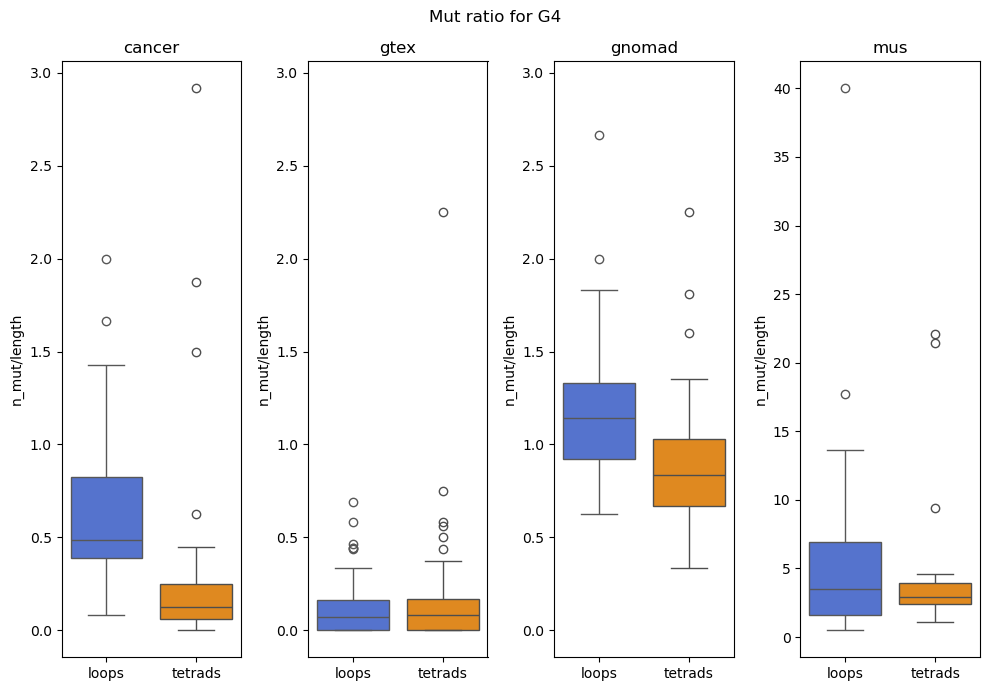

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(10, 7))
data_name_list = ['cancer', 'gtex', 'gnomad', 'mus']
df_list = [[df_loop_cancer, df_tetrads_cancer], [df_loops_gtex, df_tetrads_gtex], 
           [df_loops_gnom, df_tetrads_gnom], [df_loop_mut_mus, df_tetrads_mut_mus]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 4
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4')

plt.tight_layout()
plt.show()

## Common plot for Mut ratio (n_mut/length)
#### gnom AF_het < 0,0001 , helix AF_het < 0,00005

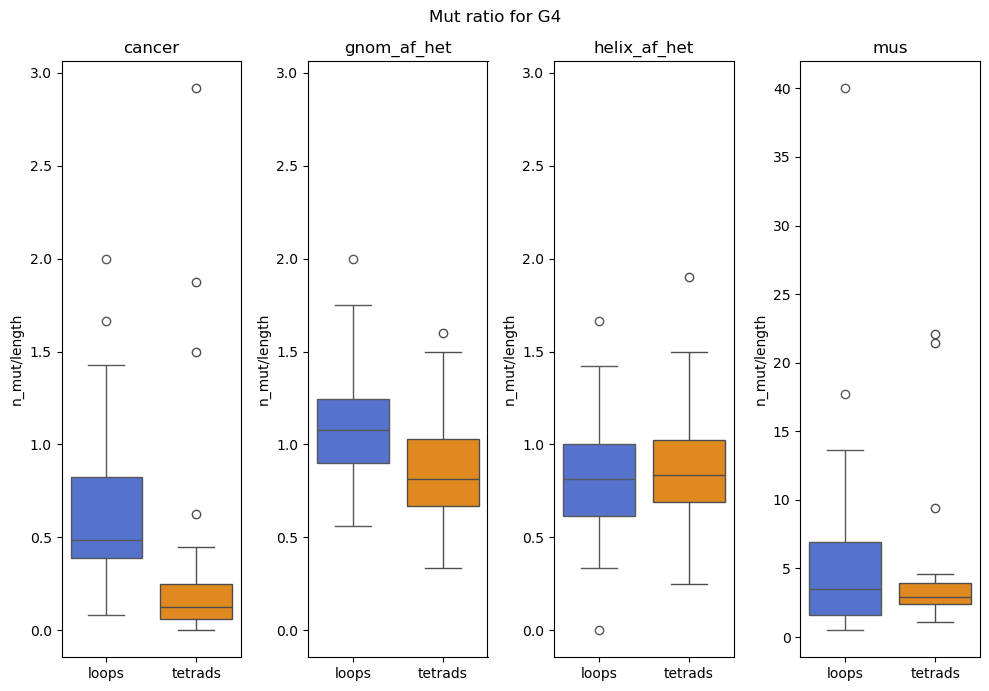

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer, df_tetrads_cancer], [df_loops_gnom_af_het, df_tetrads_gnom_af_het], 
           [df_loops_helix_af_het, df_tetrads_helix_af_het], [df_loop_mut_mus, df_tetrads_mut_mus]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 4
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4')

plt.tight_layout()
plt.show()

#### gnom AF_het < 0,00001 , helix AF_het < 0,00001 (do not reran)

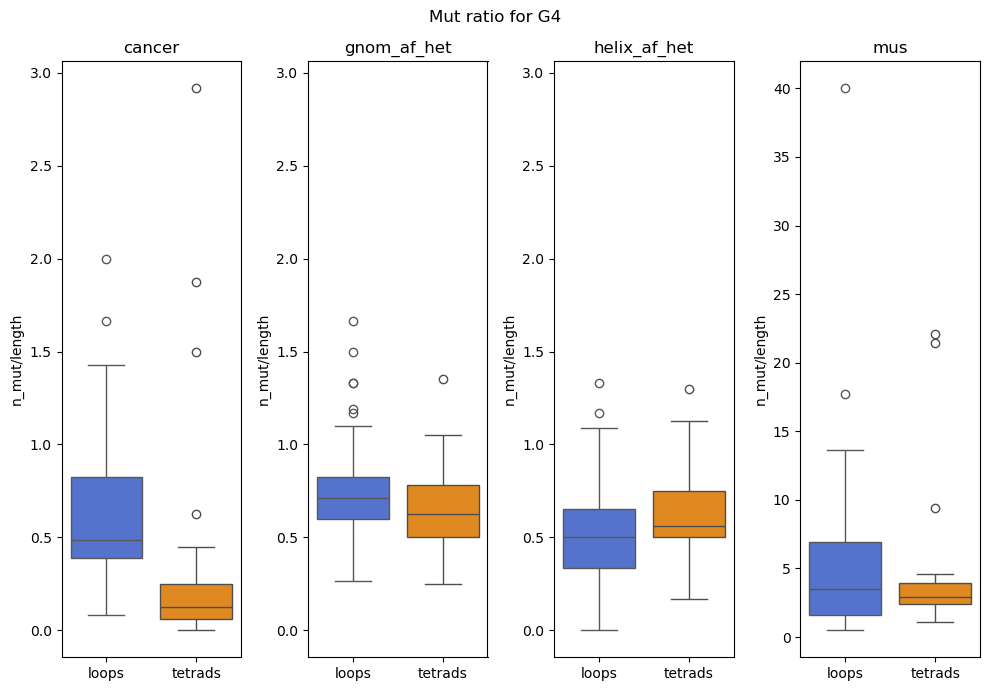

In [51]:
fig, axs = plt.subplots(1, 4, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer, df_tetrads_cancer], [df_loops_gnom_af_het, df_tetrads_gnom_af_het], 
           [df_loops_helix_af_het, df_tetrads_helix_af_het], [df_loop_mut_mus, df_tetrads_mut_mus]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 4
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/length', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

axs[1].sharey(axs[0])
axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4')

plt.tight_layout()
plt.show()

## Common plot for Mut ratio (Normalising on MutSpec)
#### mutspec look in data_preparation

### Without D-loop

In [27]:
# A C G T see data_preparation.ipynb
mutSpecs_gnom_wd_loop = [0.24327154864734377,
 0.2164950061125338,
 0.27844279785621256,
 0.2617906473839097]

In [28]:
mutSpecs_helix_wd_loop = [0.29264995816473227,
 0.2964707233207291,
 0.19238831712213897,
 0.21849100139239963]

In [29]:
mutSpecs_cancer_wd_loop = [0.04112244953486498,
 0.05057804811814163,
 0.7087115397940603,
 0.19958796255293318]

#### Count MutSpec for intervals (loops/tetrads) **gnom**

In [30]:
df_loops_gnom_af_het['MutSpec_wd_of_interval'] = df_loops_gnom_af_het['A']*mutSpecs_gnom_wd_loop[0] + df_loops_gnom_af_het['C']*mutSpecs_gnom_wd_loop[1] + \
    df_loops_gnom_af_het['G']*mutSpecs_gnom_wd_loop[2] + df_loops_gnom_af_het['T']*mutSpecs_gnom_wd_loop[3]

In [31]:
df_loops_gnom_af_het['n_mut/MutSpec_wd'] = df_loops_gnom_af_het['number_of_Mut']/df_loops_gnom_af_het['MutSpec_wd_of_interval']

In [32]:
df_tetrads_gnom_af_het['MutSpec_wd_of_interval'] = df_tetrads_gnom_af_het['A']*mutSpecs_gnom_wd_loop[0] + df_tetrads_gnom_af_het['C']*mutSpecs_gnom_wd_loop[1] + \
    df_tetrads_gnom_af_het['G']*mutSpecs_gnom_wd_loop[2] + df_tetrads_gnom_af_het['T']*mutSpecs_gnom_wd_loop[3]

In [33]:
df_tetrads_gnom_af_het['n_mut/MutSpec_wd'] = df_tetrads_gnom_af_het['number_of_Mut']/df_tetrads_gnom_af_het['MutSpec_wd_of_interval']

#### Count MutSpec for intervals (loops/tetrads) **helix**

In [34]:
df_loops_helix_af_het['MutSpec_wd_of_interval'] = df_loops_helix_af_het['A']*mutSpecs_helix_wd_loop[0] + df_loops_helix_af_het['C']*mutSpecs_helix_wd_loop[1] + \
    df_loops_helix_af_het['G']*mutSpecs_helix_wd_loop[2] + df_loops_helix_af_het['T']*mutSpecs_helix_wd_loop[3]

In [35]:
df_loops_helix_af_het['n_mut/MutSpec_wd'] = df_loops_helix_af_het['number_of_Mut']/df_loops_helix_af_het['MutSpec_wd_of_interval']

In [36]:
df_tetrads_helix_af_het['MutSpec_wd_of_interval'] = df_tetrads_helix_af_het['A']*mutSpecs_helix_wd_loop[0] + df_tetrads_helix_af_het['C']*mutSpecs_helix_wd_loop[1] + \
    df_tetrads_helix_af_het['G']*mutSpecs_helix_wd_loop[2] + df_tetrads_helix_af_het['T']*mutSpecs_helix_wd_loop[3]

In [37]:
df_tetrads_helix_af_het['n_mut/MutSpec_wd'] = df_tetrads_helix_af_het['number_of_Mut']/df_tetrads_helix_af_het['MutSpec_wd_of_interval']

#### Count MutSpec for intervals (loops/tetrads) **cancer**

In [38]:
df_loop_cancer['MutSpec_wd_of_interval'] = df_loop_cancer['A']*mutSpecs_cancer_wd_loop[0] + df_loop_cancer['C']*mutSpecs_cancer_wd_loop[1] + \
    df_loop_cancer['G']*mutSpecs_cancer_wd_loop[2] + df_loop_cancer['T']*mutSpecs_cancer_wd_loop[3]

In [39]:
df_loop_cancer['n_mut/MutSpec_wd'] = df_loop_cancer['number_of_Mut']/df_loop_cancer['MutSpec_wd_of_interval']

In [40]:
df_tetrads_cancer['MutSpec_wd_of_interval'] = df_tetrads_cancer['A']*mutSpecs_cancer_wd_loop[0] + df_tetrads_cancer['C']*mutSpecs_cancer_wd_loop[1] + \
    df_tetrads_cancer['G']*mutSpecs_cancer_wd_loop[2] + df_tetrads_cancer['T']*mutSpecs_cancer_wd_loop[3]

In [41]:
df_tetrads_cancer['n_mut/MutSpec_wd'] = df_tetrads_cancer['number_of_Mut']/df_tetrads_cancer['MutSpec_wd_of_interval']

### Plot wd_loop

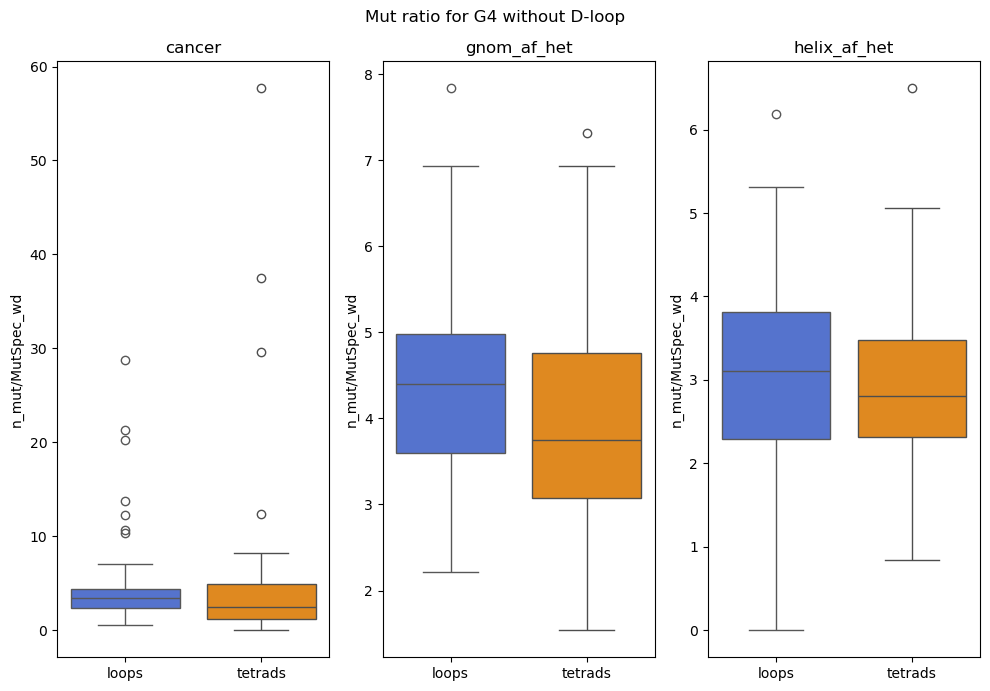

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer, df_tetrads_cancer], [df_loops_gnom_af_het, df_tetrads_gnom_af_het], 
           [df_loops_helix_af_het, df_tetrads_helix_af_het]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 3
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/MutSpec_wd', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/MutSpec_wd', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

# axs[1].sharey(axs[0])
# axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4 without D-loop')

plt.tight_layout()
plt.show()

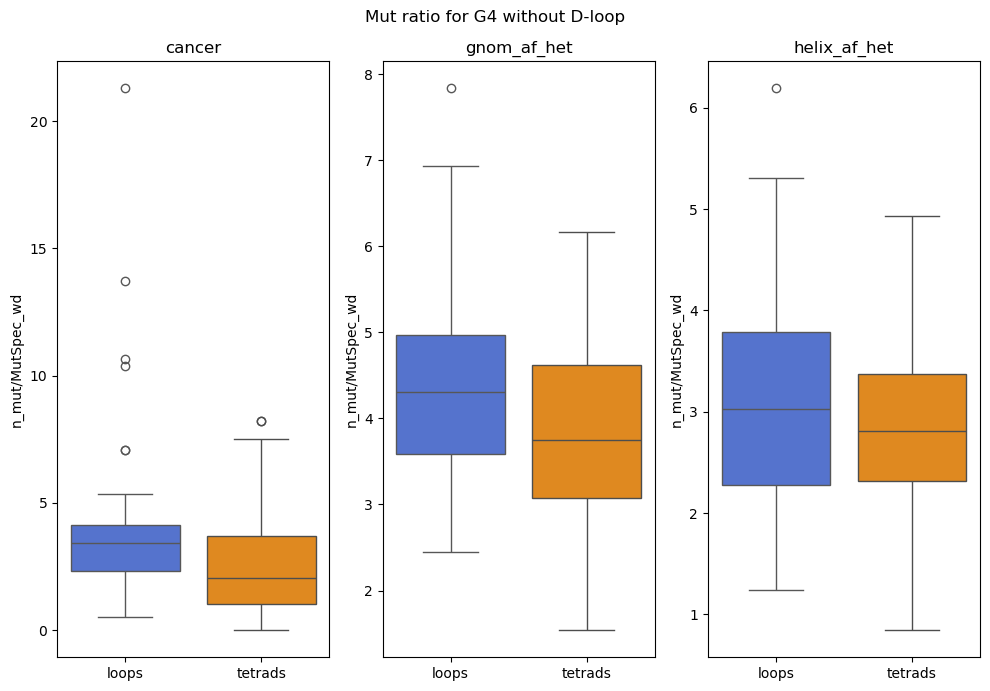

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer[~df_loop_cancer['G4_id'].isin(g4_in_dloop)], df_tetrads_cancer[~df_tetrads_cancer['G4_id'].isin(g4_in_dloop)]], 
           [df_loops_gnom_af_het[~df_loops_gnom_af_het['G4_id'].isin(g4_in_dloop)], df_tetrads_gnom_af_het[~df_tetrads_gnom_af_het['G4_id'].isin(g4_in_dloop)]], 
           [df_loops_helix_af_het[~df_loops_helix_af_het['G4_id'].isin(g4_in_dloop)], df_tetrads_helix_af_het[~df_tetrads_helix_af_het['G4_id'].isin(g4_in_dloop)]]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 3
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/MutSpec_wd', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/MutSpec_wd', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

# axs[1].sharey(axs[0])
# axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4 without D-loop')

plt.tight_layout()
plt.show()

### D-loop

In [43]:
# A C G T
mutSpecs_gnom_d_loop = [0.27765464680177154,
 0.22994290178765142,
 0.2490618944614847,
 0.24334055694909235]

In [44]:
mutSpecs_helix_d_loop = [0.26641798667287353,
 0.25613318535843865,
 0.23876647501928563,
 0.23868235294940218]

In [45]:
mutSpecs_cancer_d_loop = [0.11301911530513416,
 0.24119631452771007,
 0.39754803164886576,
 0.2482365385182901]

#### Count MutSpec for intervals (loops/tetrads) **gnom**

In [46]:
df_loops_gnom_af_het['MutSpec_d_of_interval'] = df_loops_gnom_af_het['A']*mutSpecs_gnom_d_loop[0] + df_loops_gnom_af_het['C']*mutSpecs_gnom_d_loop[1] + \
    df_loops_gnom_af_het['G']*mutSpecs_gnom_d_loop[2] + df_loops_gnom_af_het['T']*mutSpecs_gnom_d_loop[3]

In [47]:
df_loops_gnom_af_het['n_mut/MutSpec_d'] = df_loops_gnom_af_het['number_of_Mut']/df_loops_gnom_af_het['MutSpec_d_of_interval']

In [48]:
df_tetrads_gnom_af_het['MutSpec_d_of_interval'] = df_tetrads_gnom_af_het['A']*mutSpecs_gnom_d_loop[0] + df_tetrads_gnom_af_het['C']*mutSpecs_gnom_d_loop[1] + \
    df_tetrads_gnom_af_het['G']*mutSpecs_gnom_d_loop[2] + df_tetrads_gnom_af_het['T']*mutSpecs_gnom_d_loop[3]

In [49]:
df_tetrads_gnom_af_het['n_mut/MutSpec_d'] = df_tetrads_gnom_af_het['number_of_Mut']/df_tetrads_gnom_af_het['MutSpec_d_of_interval']

#### Count MutSpec for intervals (loops/tetrads) **helix**

In [50]:
df_loops_helix_af_het['MutSpec_d_of_interval'] = df_loops_helix_af_het['A']*mutSpecs_helix_d_loop[0] + df_loops_helix_af_het['C']*mutSpecs_helix_d_loop[1] + \
    df_loops_helix_af_het['G']*mutSpecs_helix_d_loop[2] + df_loops_helix_af_het['T']*mutSpecs_helix_d_loop[3]

In [51]:
df_loops_helix_af_het['n_mut/MutSpec_d'] = df_loops_helix_af_het['number_of_Mut']/df_loops_helix_af_het['MutSpec_d_of_interval']

In [52]:
df_tetrads_helix_af_het['MutSpec_d_of_interval'] = df_tetrads_helix_af_het['A']*mutSpecs_helix_d_loop[0] + df_tetrads_helix_af_het['C']*mutSpecs_helix_d_loop[1] + \
    df_tetrads_helix_af_het['G']*mutSpecs_helix_d_loop[2] + df_tetrads_helix_af_het['T']*mutSpecs_helix_d_loop[3]

In [53]:
df_tetrads_helix_af_het['n_mut/MutSpec_d'] = df_tetrads_helix_af_het['number_of_Mut']/df_tetrads_helix_af_het['MutSpec_d_of_interval']

#### Count MutSpec for intervals (loops/tetrads) **cancer**

In [54]:
df_loop_cancer['MutSpec_d_of_interval'] = df_loop_cancer['A']*mutSpecs_cancer_d_loop[0] + df_loop_cancer['C']*mutSpecs_cancer_d_loop[1] + \
    df_loop_cancer['G']*mutSpecs_cancer_d_loop[2] + df_loop_cancer['T']*mutSpecs_cancer_d_loop[3]

In [55]:
df_loop_cancer['n_mut/MutSpec_d'] = df_loop_cancer['number_of_Mut']/df_loop_cancer['MutSpec_d_of_interval']

In [56]:
df_tetrads_cancer['MutSpec_d_of_interval'] = df_tetrads_cancer['A']*mutSpecs_cancer_d_loop[0] + df_tetrads_cancer['C']*mutSpecs_cancer_d_loop[1] + \
    df_tetrads_cancer['G']*mutSpecs_cancer_d_loop[2] + df_tetrads_cancer['T']*mutSpecs_cancer_d_loop[3]

In [57]:
df_tetrads_cancer['n_mut/MutSpec_d'] = df_tetrads_cancer['number_of_Mut']/df_tetrads_cancer['MutSpec_d_of_interval']

### Plot d_loop

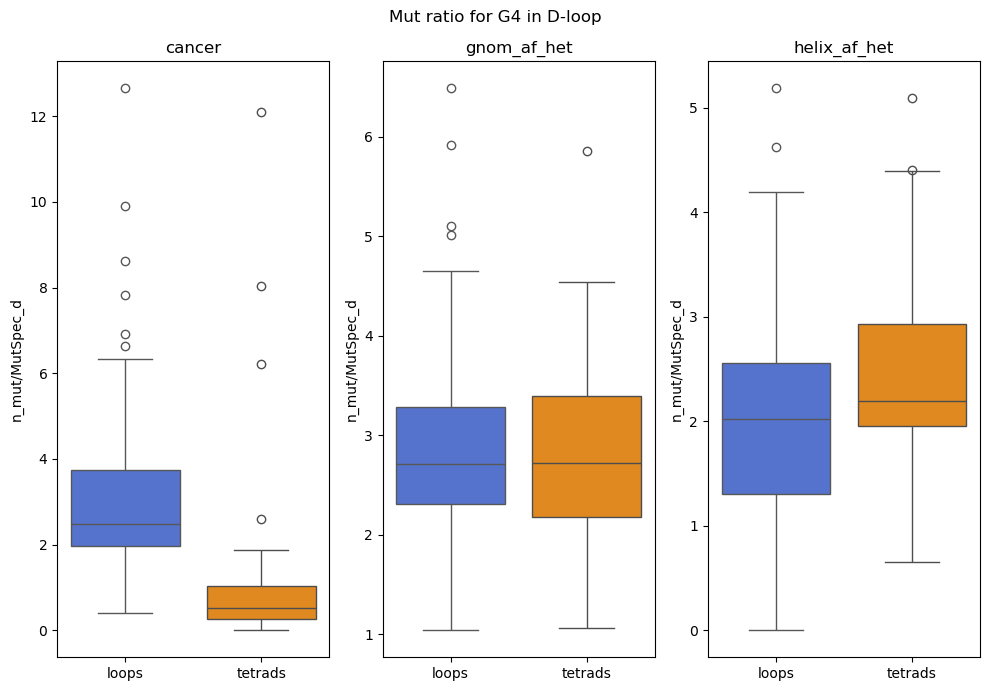

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer, df_tetrads_cancer], [df_loops_gnom_af_het, df_tetrads_gnom_af_het], 
           [df_loops_helix_af_het, df_tetrads_helix_af_het]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 3
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/MutSpec_d', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/MutSpec_d', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

# axs[1].sharey(axs[0])
# axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4 in D-loop')

plt.tight_layout()
plt.show()

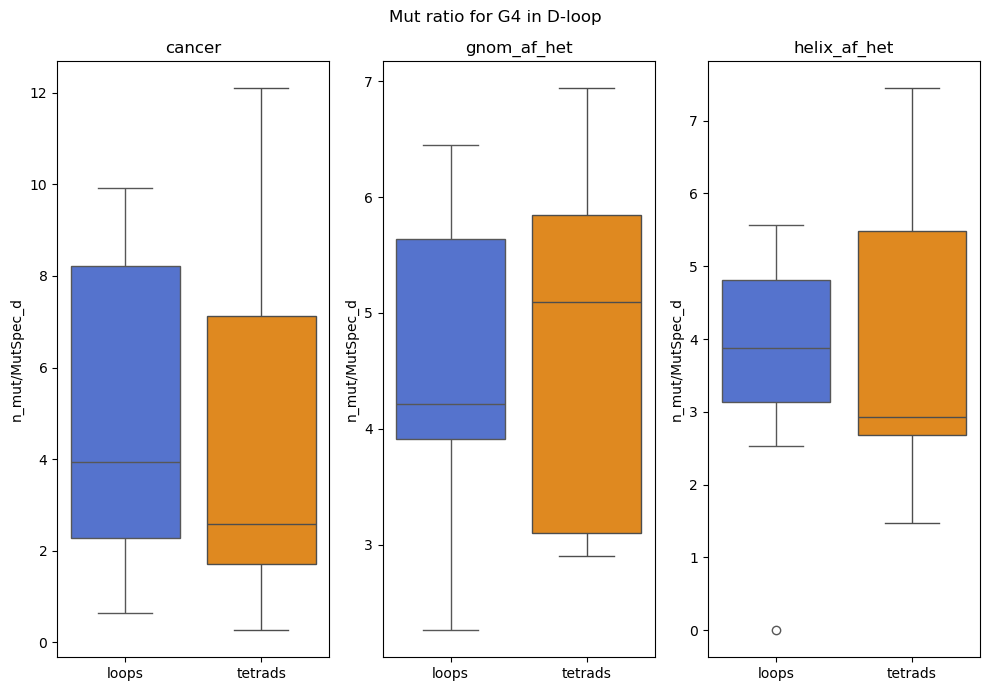

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(10, 7))
data_name_list = ['cancer', 'gnom_af_het', 'helix_af_het', 'mus']
df_list = [[df_loop_cancer[df_loop_cancer['G4_id'].isin(g4_in_dloop)], df_tetrads_cancer[df_tetrads_cancer['G4_id'].isin(g4_in_dloop)]], 
           [df_loops_gnom_af_het[df_loops_gnom_af_het['G4_id'].isin(g4_in_dloop)], df_tetrads_gnom_af_het[df_tetrads_gnom_af_het['G4_id'].isin(g4_in_dloop)]], 
           [df_loops_helix_af_het[df_loops_helix_af_het['G4_id'].isin(g4_in_dloop)], df_tetrads_helix_af_het[df_tetrads_helix_af_het['G4_id'].isin(g4_in_dloop)]]]

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-45, -30, -15, 0, 15, 30, 45]

for i, data_name, df in zip([*range(len(data_name_list))], data_name_list, df_list):
    row = i % 3
    sns.boxplot(data=df[0], 
                 x='side', y='n_mut/MutSpec_d', ax=axs[row], color=colors[0]) \
        .set(title=data_name, xlabel=None)
    sns.boxplot(data=df[1], 
                 x='side', y='n_mut/MutSpec_d', ax=axs[row], color=colors[1]) \
        .set(title=data_name, xlabel=None)

# axs[1].sharey(axs[0])
# axs[2].sharey(axs[0])

# # Create custom legend handles and labels
# handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])

plt.suptitle('Mut ratio for G4 in D-loop')

plt.tight_layout()
plt.show()

# Compare reostat

In [66]:
s_loops_cancer = pd.concat([df_loop_cancer[df_loop_cancer['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_loop_cancer[df_loop_cancer['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_loop_cancer[~df_loop_cancer['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [67]:
s_tetrads_cancer = pd.concat([df_tetrads_cancer[df_tetrads_cancer['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_tetrads_cancer[df_tetrads_cancer['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_tetrads_cancer[~df_tetrads_cancer['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [68]:
s_loops_gnom_het = pd.concat([df_loops_gnom_af_het[df_loops_gnom_af_het['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_loops_gnom_af_het[df_loops_gnom_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_loops_gnom_af_het[~df_loops_gnom_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [69]:
s_tetrads_gnom_het = pd.concat([df_tetrads_gnom_af_het[df_tetrads_gnom_af_het['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_tetrads_gnom_af_het[df_tetrads_gnom_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_tetrads_gnom_af_het[~df_tetrads_gnom_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [70]:
s_loops_helix_het = pd.concat([df_loops_helix_af_het[df_loops_helix_af_het['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_loops_helix_af_het[df_loops_helix_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_loops_helix_af_het[~df_loops_helix_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [71]:
s_tetrads_helix_het = pd.concat([df_tetrads_helix_af_het[df_tetrads_helix_af_het['G4_id'] == 1]['n_mut/MutSpec_d'], 
           df_tetrads_helix_af_het[df_tetrads_helix_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_d'][1:], 
           df_tetrads_helix_af_het[~df_tetrads_helix_af_het['G4_id'].isin(g4_in_dloop)]['n_mut/MutSpec_wd']])

In [72]:
d = {'n_mut/mutSpec_loops_cancer':s_loops_cancer, 'n_mut/mutSpec_tetrads_cancer':s_tetrads_cancer,
          'n_mut/mutSpec_loops_gnom':s_loops_gnom_het, 'n_mut/mutSpec_tetrads_gnom':s_tetrads_gnom_het,
          'n_mut/mutSpec_loops_helix':s_loops_helix_het, 'n_mut/mutSpec_tetrads_helix':s_tetrads_helix_het}

In [73]:
n_mut_mutSpec = pd.DataFrame(data=d)

In [74]:
n_mut_mutSpec.insert(loc=0, column='G4_id', value=df_loop_cancer['G4_id'])

In [75]:
n_mut_mutSpec[1:].describe()

,G4_id,n_mut/mutSpec_loops_cancer,n_mut/mutSpec_tetrads_cancer,n_mut/mutSpec_loops_gnom,n_mut/mutSpec_tetrads_gnom,n_mut/mutSpec_loops_helix,n_mut/mutSpec_tetrads_helix
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,34.500000,3.994661,2.924799,4.435078,3.997997,3.277476,3.047297
std,19.196354,3.226696,2.675853,1.146449,1.139536,1.088076,1.089512
min,2.000000,0.509465,0.000000,2.261827,1.539681,1.244105,0.843254
25%,18.250000,2.331738,1.046160,3.595072,3.079363,2.312790,2.330039
50%,34.500000,3.409544,2.279274,4.308137,3.801088,3.151920,2.810845
75%,50.750000,4.293957,4.644884,4.986312,4.835562,3.868439,3.532485
max,67.000000,21.289214,12.092501,7.833723,6.938037,6.191094,7.443372


In [76]:
n_mut_mutSpec.loc[0].to_frame()

,0
G4_id,1.000000
n_mut/mutSpec_loops_cancer,8.616921
n_mut/mutSpec_tetrads_cancer,1.551919
n_mut/mutSpec_loops_gnom,3.763265
n_mut/mutSpec_tetrads_gnom,3.249845
n_mut/mutSpec_loops_helix,0.000000
n_mut/mutSpec_tetrads_helix,1.470343


In [77]:
n_mut_mutSpec

,G4_id,n_mut/mutSpec_loops_cancer,n_mut/mutSpec_tetrads_cancer,n_mut/mutSpec_loops_gnom,n_mut/mutSpec_tetrads_gnom,n_mut/mutSpec_loops_helix,n_mut/mutSpec_tetrads_helix
0,1,8.616921,1.551919,3.763265,3.249845,0.000000,1.470343
1,2,0.645187,0.268027,4.053596,2.951595,4.216510,2.920834
2,3,1.417403,1.862981,6.452621,6.938037,5.569473,7.443372
3,4,7.829665,2.591250,5.537919,5.164326,5.413209,5.124287
64,65,9.909644,8.040818,5.744394,5.098210,3.879428,2.434028
...,...,...,...,...,...,...,...
59,60,4.018449,3.750970,3.269505,5.156564,2.446411,4.008683
60,61,3.450269,3.707142,4.607863,4.619044,3.799955,3.373014
61,62,1.957552,1.647619,3.405759,5.773805,3.884830,4.216268
62,63,4.678613,1.235714,4.958921,3.464283,3.726409,2.740574


In [92]:
g4_functional_indexs = [0, 64]

In [101]:
n_mut_mutSpec.loc[g4_functional_indexs]

,G4_id,n_mut/mutSpec_loops_cancer,n_mut/mutSpec_tetrads_cancer,n_mut/mutSpec_loops_gnom,n_mut/mutSpec_tetrads_gnom,n_mut/mutSpec_loops_helix,n_mut/mutSpec_tetrads_helix
0,1,8.616921,1.551919,3.763265,3.249845,0.000000,1.470343
64,65,9.909644,8.040818,5.744394,5.098210,3.879428,2.434028


In [134]:
n_mut_mutSpec.drop([0, 64], axis=0).loc[:, n_mut_mutSpec.columns != 'G4_id'][:5]

,n_mut/mutSpec_loops_cancer,n_mut/mutSpec_tetrads_cancer,n_mut/mutSpec_loops_gnom,n_mut/mutSpec_tetrads_gnom,n_mut/mutSpec_loops_helix,n_mut/mutSpec_tetrads_helix
1,0.645187,0.268027,4.053596,2.951595,4.216510,2.920834
2,1.417403,1.862981,6.452621,6.938037,5.569473,7.443372
3,7.829665,2.591250,5.537919,5.164326,5.413209,5.124287
65,3.931594,12.092501,4.210236,6.523359,3.737031,5.856328
66,3.138385,6.219000,2.261827,2.899270,2.528564,2.928164


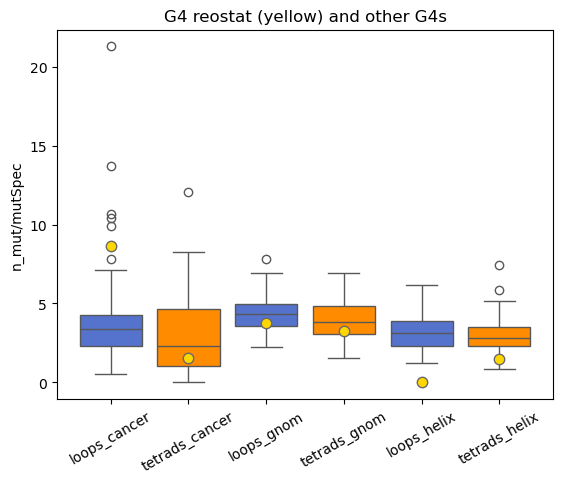

In [125]:
g = sns.boxplot(x="variable", y="value", data=pd.melt(n_mut_mutSpec.loc[:, n_mut_mutSpec.columns != 'G4_id'][1:]), color='royalblue')

## Change box color
# Select which box you want to change    
box_tetrads = g.patches[1::2]

# Change the appearance of that box
for box in box_tetrads:
    box.set_facecolor('darkorange')

## Add dots
# get the x-positions of the tick label for each category
xpos = {c.get_text(): x for c, x in zip(g.get_xticklabels(), g.get_xticks())}

# plot the G4 reostat lines
for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[0][1:][cat],
        color='gold',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

## Add new xticks
g.set_xticks(range(0, 6))
g.set_xticklabels(['loops_cancer', 'tetrads_cancer', 'loops_gnom', 'tetrads_gnom', 'loops_helix', 'tetrads_helix'], rotation=30)
g.set(xlabel=None, ylabel='n_mut/mutSpec', title='G4 reostat (yellow) and other G4s')
plt.show()

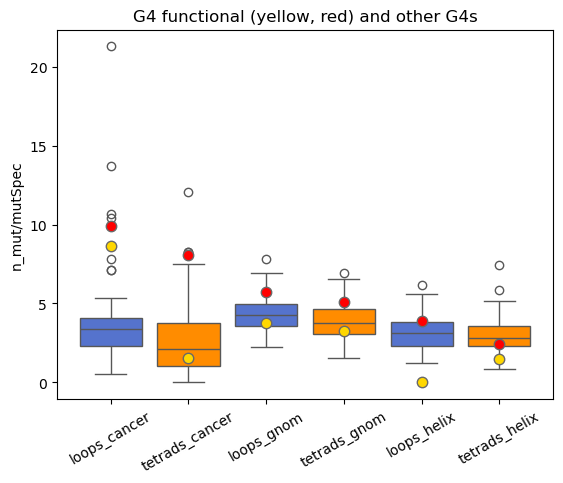

In [129]:
g = sns.boxplot(x="variable", y="value", 
                data=pd.melt(n_mut_mutSpec.drop([0, 64], axis=0).loc[:, n_mut_mutSpec.columns != 'G4_id']), 
                color='royalblue')

## Change box color
# Select which box you want to change    
box_tetrads = g.patches[1::2]

# Change the appearance of that box
for box in box_tetrads:
    box.set_facecolor('darkorange')

## Add dots
# get the x-positions of the tick label for each category
xpos = {c.get_text(): x for c, x in zip(g.get_xticklabels(), g.get_xticks())}

# plot the G4 reostat lines
for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[0][1:][cat],
        color='gold',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[64][1:][cat],
        color='red',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

## Add new xticks
g.set_xticks(range(0, 6))
g.set_xticklabels(['loops_cancer', 'tetrads_cancer', 'loops_gnom', 'tetrads_gnom', 'loops_helix', 'tetrads_helix'], rotation=30)
g.set(xlabel=None, ylabel='n_mut/mutSpec', title='G4 functional (yellow, red) and other G4s')
plt.show()

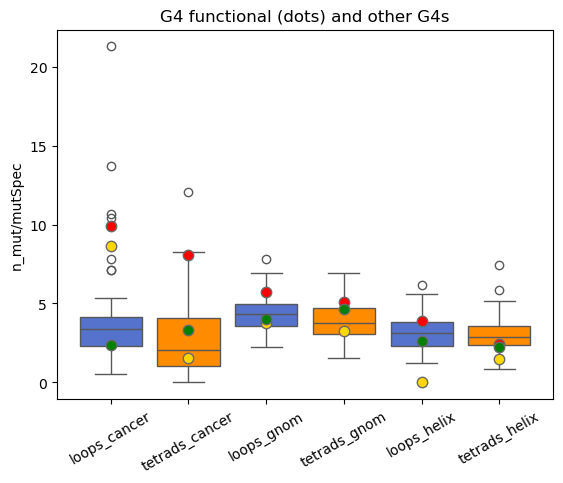

In [143]:
g = sns.boxplot(x="variable", y="value", 
                data=pd.melt(n_mut_mutSpec.drop([0, 64, 7], axis=0).loc[:, n_mut_mutSpec.columns != 'G4_id']), 
                color='royalblue')

## Change box color
# Select which box you want to change    
box_tetrads = g.patches[1::2]

# Change the appearance of that box
for box in box_tetrads:
    box.set_facecolor('darkorange')

## Add dots
# get the x-positions of the tick label for each category
xpos = {c.get_text(): x for c, x in zip(g.get_xticklabels(), g.get_xticks())}

# plot the G4 reostat lines
for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[0][1:][cat],
        color='gold',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[64][1:][cat],
        color='red',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[7][1:][cat],
        color='green',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

## Add new xticks
g.set_xticks(range(0, 6))
g.set_xticklabels(['loops_cancer', 'tetrads_cancer', 'loops_gnom', 'tetrads_gnom', 'loops_helix', 'tetrads_helix'], rotation=30)
g.set(xlabel=None, ylabel='n_mut/mutSpec', title='G4 functional (dots) and other G4s')
plt.show()

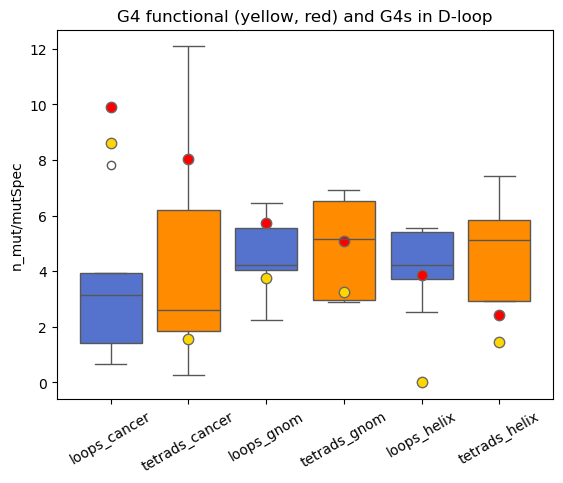

In [139]:
g = sns.boxplot(x="variable", y="value", 
                data=pd.melt(n_mut_mutSpec.drop([0, 64], axis=0).loc[:, n_mut_mutSpec.columns != 'G4_id'][:5]), 
                color='royalblue')

## Change box color
# Select which box you want to change    
box_tetrads = g.patches[1::2]

# Change the appearance of that box
for box in box_tetrads:
    box.set_facecolor('darkorange')

## Add dots
# get the x-positions of the tick label for each category
xpos = {c.get_text(): x for c, x in zip(g.get_xticklabels(), g.get_xticks())}

# plot the G4 reostat lines
for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[0][1:][cat],
        color='gold',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

for cat in n_mut_mutSpec.columns[1:]:
    g.plot(
        xpos[cat],
        n_mut_mutSpec.loc[64][1:][cat],
        color='red',
        ms=15,
        mec='dimgray',
        mew=1,
        marker='.'
    )

## Add new xticks
g.set_xticks(range(0, 6))
g.set_xticklabels(['loops_cancer', 'tetrads_cancer', 'loops_gnom', 'tetrads_gnom', 'loops_helix', 'tetrads_helix'], rotation=30)
g.set(xlabel=None, ylabel='n_mut/mutSpec', title='G4 functional (yellow, red) and G4s in D-loop')
plt.show()

In [141]:
n_mut_mutSpec[n_mut_mutSpec['G4_id'] == 8]

,G4_id,n_mut/mutSpec_loops_cancer,n_mut/mutSpec_tetrads_cancer,n_mut/mutSpec_loops_gnom,n_mut/mutSpec_tetrads_gnom,n_mut/mutSpec_loops_helix,n_mut/mutSpec_tetrads_helix
7,8,2.340884,3.295237,4.040559,4.619044,2.648609,2.248676


# COS SIM

In [74]:
df_cancer_cossim = df_loop_cancer[['G4_id', 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C', 'T>G']]

In [75]:
df_cancer_cossim = df_cancer_cossim.rename({'A>C':'A>C_l', 'A>G':'A>G_l', 'A>T':'A>T_l', 
                                            'C>A':'C>A_l', 'C>G':'C>G_l', 'C>T':'C>T_l', 
                                            'G>A':'G>A_l', 'G>C':'G>C_l', 'G>T':'G>T_l', 
                                            'T>A':'T>A_l', 'T>C':'T>C_l', 'T>G':'T>G_l'}, axis=1)

In [76]:
df_cancer_cossim = df_cancer_cossim.merge(df_tetrads_cancer[['G4_id', 
                                                            'A>C', 'A>G', 'A>T', 
                                                            'C>A', 'C>G', 'C>T', 
                                                            'G>A', 'G>C', 'G>T', 
                                                            'T>A', 'T>C', 'T>G']])

In [77]:
df_cancer_cossim = df_cancer_cossim.rename({'A>C':'A>C_t', 'A>G':'A>G_t', 'A>T':'A>T_t', 
                                            'C>A':'C>A_t', 'C>G':'C>G_t', 'C>T':'C>T_t', 
                                            'G>A':'G>A_t', 'G>C':'G>C_t', 'G>T':'G>T_t', 
                                            'T>A':'T>A_t', 'T>C':'T>C_t', 'T>G':'T>G_t'}, axis=1)

In [78]:
df_cancer_cossim

,G4_id,A>C_l,A>G_l,A>T_l,C>A_l,C>G_l,C>T_l,G>A_l,G>C_l,G>T_l,...,A>T_t,C>A_t,C>G_t,C>T_t,G>A_t,G>C_t,G>T_t,T>A_t,T>C_t,T>G_t
0,1,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,6.0,0,0,0,0,0.0,0
1,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,1.0,0,0,0,0,0.0,0
2,3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0,0.0,0.0,8.0,0,0,0,0,1.0,0
3,4,0.0,10.0,0.0,0.0,0.0,1.0,17.0,0.0,2.0,...,0,3.0,0.0,7.0,0,0,0,0,0.0,0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0,0.0,0.0,0.0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0.0,0.0,1.0,0,0,0,0,0.0,0
63,64,4.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0,0.0,0.0,5.0,0,0,0,0,0.0,0
64,65,1.0,3.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0,4.0,1.0,23.0,0,0,0,0,0.0,0
65,66,0.0,12.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,...,0,1.0,2.0,32.0,0,0,0,0,0.0,0


In [115]:
dis_l_cancer = spatial.distance.cdist(df_loop_cancer[[ 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C', 'T>G']], 
              df_loop_cancer[[ 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C', 'T>G']], 
              metric='cosine')

In [180]:
dis_t_cancer = spatial.distance.cdist(df_tetrads_cancer[[ 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C', 'T>G']], 
              df_tetrads_cancer[[ 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C', 'T>G']], 
              metric='cosine')

In [190]:
pd.DataFrame(dis_t_cancer, columns=df_tetrads_cancer['G4_id']).fillna(0).set_index(df_tetrads_cancer['G4_id'])

G4_id,1,2,3,4,5,6,7,8,9,10,...,58,59,60,61,62,63,64,65,66,67
G4_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.007722,8.085497e-02,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.0,0.105573,0.105573,0.105573,1.000000,0.000000,0.000000,1.927670e-02,2.432502e-03,1.941932e-02
2,0.000000,0.000000,0.007722,8.085497e-02,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.0,0.105573,0.105573,0.105573,1.000000,0.000000,0.000000,1.927670e-02,2.432502e-03,1.941932e-02
3,0.007722,0.007722,0.000000,8.795272e-02,0.875965,0.007722,0.0,0.007722,0.007722,1.000000,...,0.0,0.112480,0.112480,0.112480,1.000000,0.007722,0.007722,2.684997e-02,1.013584e-02,2.699149e-02
4,0.080855,0.080855,0.087953,1.110223e-16,1.000000,0.080855,0.0,0.080855,0.080855,0.721457,...,0.0,0.177892,0.177892,0.001726,0.606081,0.080855,0.080855,3.138596e-02,7.081076e-02,2.145022e-02
5,1.000000,1.000000,0.875965,1.000000e+00,0.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.000000,0.000000,0.007722,8.085497e-02,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.0,0.105573,0.105573,0.105573,1.000000,0.000000,0.000000,1.927670e-02,2.432502e-03,1.941932e-02
64,0.000000,0.000000,0.007722,8.085497e-02,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,...,0.0,0.105573,0.105573,0.105573,1.000000,0.000000,0.000000,1.927670e-02,2.432502e-03,1.941932e-02
65,0.019277,0.019277,0.026850,3.138596e-02,1.000000,0.019277,0.0,0.019277,0.019277,0.849244,...,0.0,0.122814,0.122814,0.046537,0.829439,0.019277,0.019277,2.220446e-16,1.368674e-02,4.872008e-03


In [204]:
g4_id_loc['loc'].unique()

array(['D_loop', 'rRNA', 'tRNA', 'ND1', 'ND2', 'COX1', 'COX2', '-',
       'ATP8', 'ATP6', 'COX3', 'ND3', 'ND4L', 'ND4', 'ND5', 'ND6', 'CYTB'],
      dtype=object)

In [236]:
colors_for_loc = ['grey', 
                 'limegreen', 'springgreen', 
                 'royalblue', 'blue', 
                 'pink', 'hotpink', 
                 'k',
                 'darkgoldenrod', 'goldenrod', 
                 'palevioletred', 
                 'deepskyblue', 'cyan', 'lightseagreen', 'lightskyblue', 'steelblue',
                 'darkviolet']

In [237]:
lut = dict(zip(g4_id_loc['loc'].unique(), colors_for_loc))

In [238]:
loc_colors = g4_id_loc['loc'].map(lut)

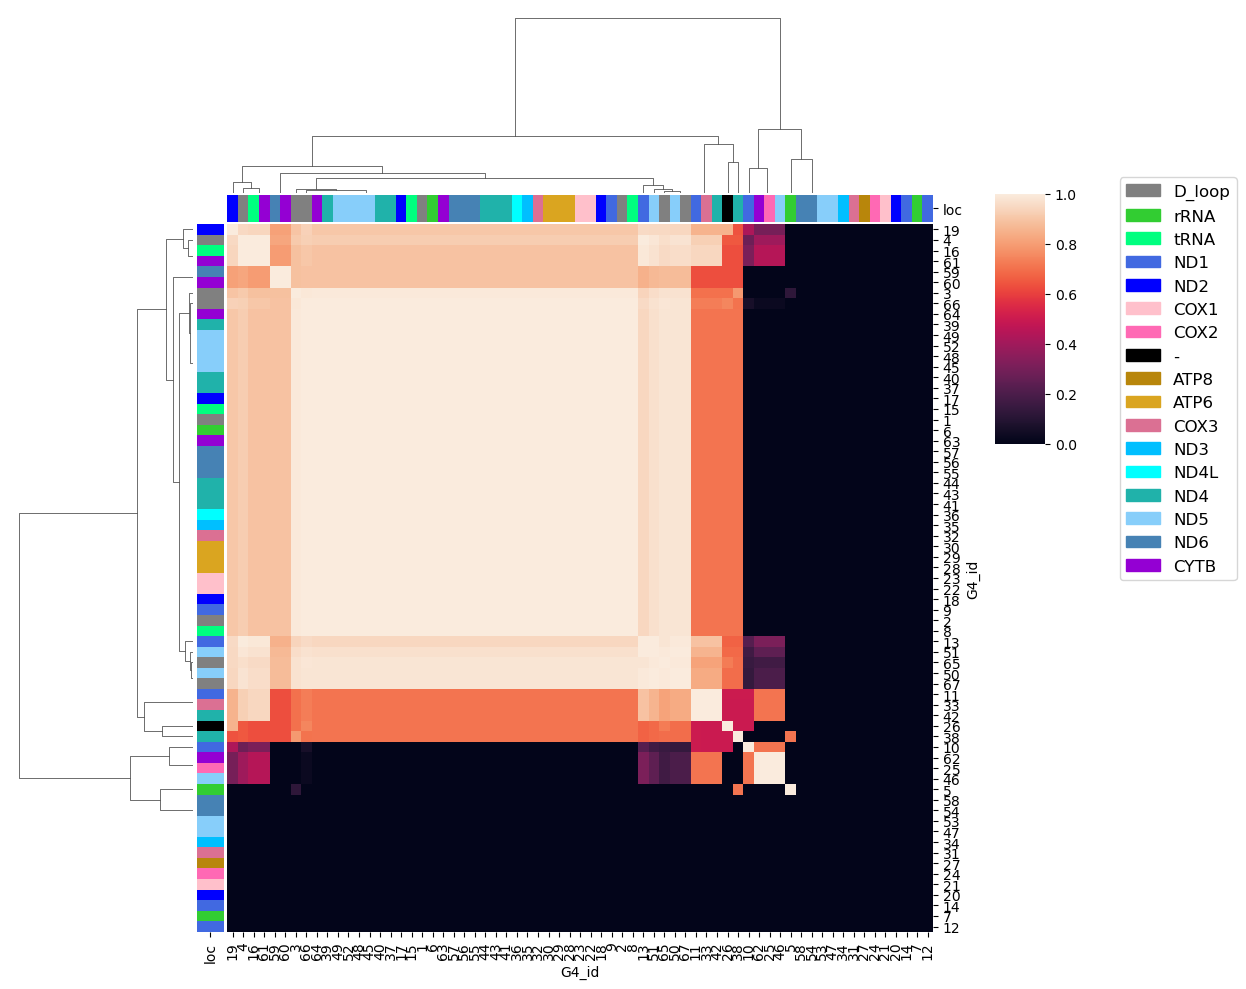

In [257]:
sns.clustermap(pd.DataFrame(1-dis_t_cancer, columns=df_tetrads_cancer['G4_id']).fillna(0).set_index(df_tetrads_cancer['G4_id']),
              xticklabels=True, yticklabels=True,
              cbar_pos=(1, 0.55, 0.05, 0.25),
              row_colors=loc_colors,
              col_colors=loc_colors)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(colors_for_loc, g4_id_loc['loc'].unique())]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(5, 1.10))

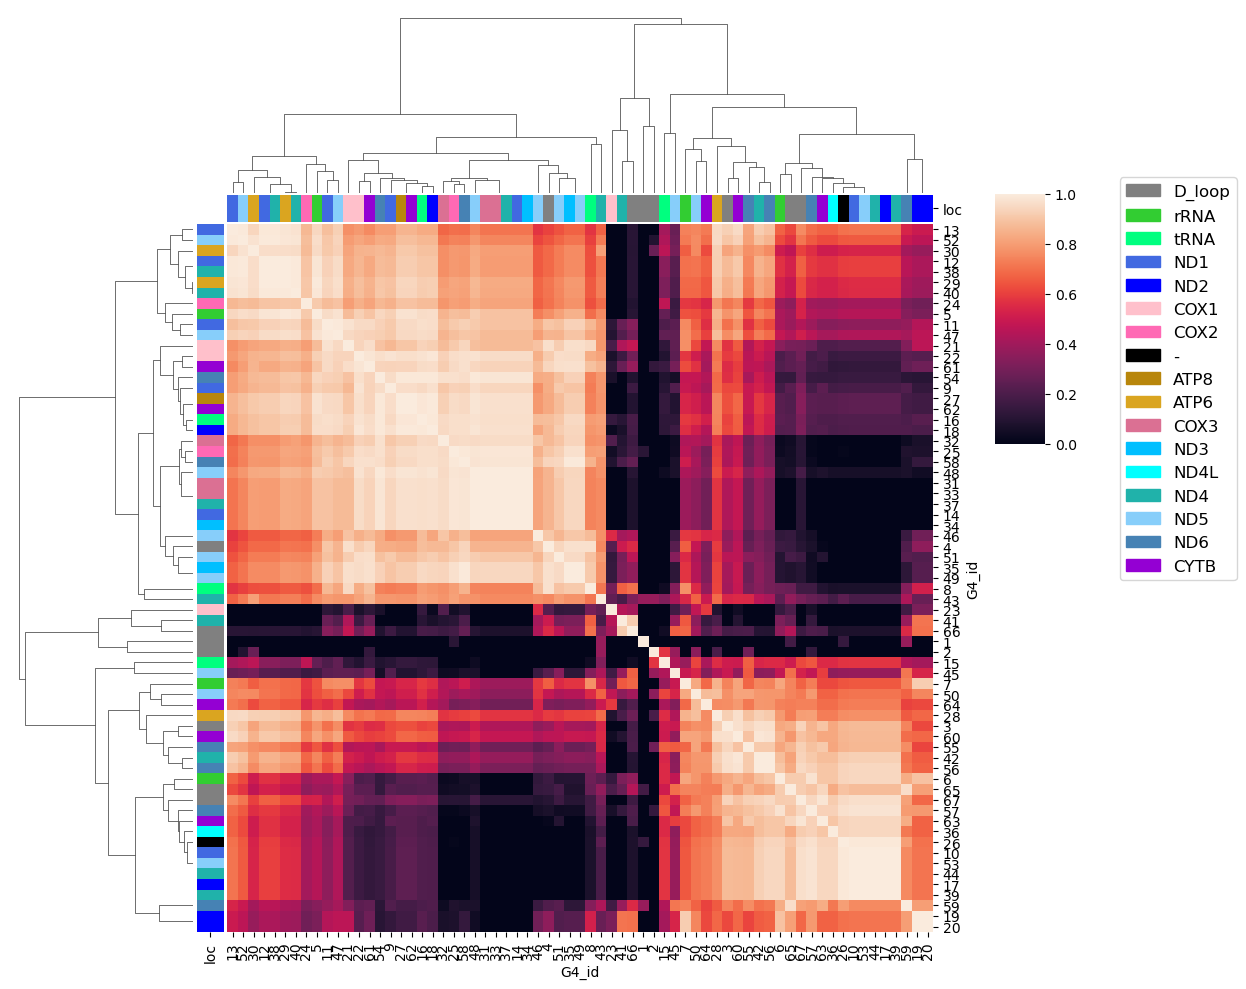

In [258]:
sns.clustermap(pd.DataFrame(1-dis_l_cancer, columns=df_tetrads_cancer['G4_id']).fillna(0).set_index(df_loop_cancer['G4_id']),
              xticklabels=True, yticklabels=True,
              cbar_pos=(1, 0.55, 0.05, 0.25),
              row_colors=loc_colors,
              col_colors=loc_colors)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(colors_for_loc, g4_id_loc['loc'].unique())]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(5, 1.10))